<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0807snow_sentencebert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 長岡技術大学 やさしい日本語 SNOW コーパスのやさしい日本語部分を sentenceBERT により検討
- date: 2022_0711
- author: 浅川伸一

In [1]:
import torch
try:
    import bit
except ImportError:
    !pip install ipynbname --upgrade > /dev/null 2>&1 
    !git clone https://github.com/ShinAsakawa/bit.git
import bit

isColab = bit.isColab
HOME = bit.HOME
%config InlineBackend.figure_format = 'retina'

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())
if isColab:
    !pip install --upgrade openpyxl
    !pip install --upgrade pandas
    !pip install --upgrade fugashi[unidic-lite]
    !pip install --upgrade ipadic
    !python -m unidic download
    !pip install transformers
    !pip install --upgrade jaconv

Cloning into 'bit'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 246 (delta 192), reused 158 (delta 144), pack-reused 0
Receiving objects: 100% (246/246), 1.11 MiB | 9.38 MiB/s, done.
Resolving deltas: 100% (192/192), done.
日付: 2022-08-06
HOSTNAME: f403642429a2
ユーザ名: root
HOME: /root
ファイル名: /fileId=1_HD_H25SKfmahcz6z220xluC0yFXlkqC
torch.__version__: 1.12.0+cu113
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568 kB 28.3 MB/s 
     |████████████████████████████████| 47.4 MB 1.3 MB/s 
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658836 sha256=6da51c2b582f93c

# やさしい日本語コーパスの取得

In [2]:
import os
import sys
import requests
import pandas as pd
import jaconv
SNOWs={'T15': {'url':"https://filedn.com/lit4DCIlHwxfS1gj9zcYuDJ/SNOW/T15-2020.1.7.xlsx"},
       'T23': {'url':"https://filedn.com/lit4DCIlHwxfS1gj9zcYuDJ/SNOW/T23-2020.1.7.xlsx"},}


for corpus in SNOWs:
    url = SNOWs[corpus]['url']
    excel_fname = corpus + '-2020.1.7.xlsx'
    if not os.path.exists(excel_fname):
        r = requests.get(url)
        with open(excel_fname, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print(f'{excel_fname} をダウンロード中 {total_length} バイト')
            f.write(r.content)

    SNOWs[corpus]['df'] = pd.read_excel(excel_fname, engine='openpyxl')
    SNOWs[corpus]['df'] = SNOWs[corpus]['df'].rename(columns={'#日本語(原文)': 'ja', 
                                                              '#やさしい日本語':'easy_ja',
                                                              '#英語(原文)':'en'})

_snow_sents = SNOWs['T15']['df']['easy_ja'].to_list() + SNOWs['T23']['df']['easy_ja'].to_list()
snow_sents = [jaconv.normalize(line, 'NFKC') for line in _snow_sents]
print(snow_sents[:3])

T15-2020.1.7.xlsx をダウンロード中 3634132 バイト
T23-2020.1.7.xlsx をダウンロード中 3641507 バイト
['誰が一番に着くか私には分かりません。', '多くの動物が人間によって殺された。', '私はテニス部員です。']


# センテンスBert の取得

In [3]:
import typing
import torch
from transformers import BertJapaneseTokenizer
from transformers import BertModel

class SentenceBertJapanese:
    def __init__(self, 
                 model_name_or_path:str, 
                 device:str=None, 
                ):
        self.tokenizer = BertJapaneseTokenizer.from_pretrained(model_name_or_path)
        self.model = BertModel.from_pretrained(model_name_or_path)
        self.model.eval()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)
        self.model.to(device)

    def _mean_pooling(self, 
                      model_output:torch.Tensor, 
                      attention_mask:torch.Tensor):
        token_embeddings = model_output[0] #First element of model_output contains all token embeddings
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    @torch.no_grad()
    def encode(self, 
               sentences:[str], 
               batch_size:int=8):
        all_embeddings = []
        iterator = range(0, len(sentences), batch_size)
        for batch_idx in iterator:
            batch = sentences[batch_idx:batch_idx + batch_size]

            encoded_input = self.tokenizer.batch_encode_plus(batch, padding="longest", 
                                           truncation=True, return_tensors="pt").to(self.device)
            model_output = self.model(**encoded_input)
            sentence_embeddings = self._mean_pooling(model_output, encoded_input["attention_mask"]).to('cpu')

            all_embeddings.extend(sentence_embeddings)

        # return torch.stack(all_embeddings).numpy()
        return torch.stack(all_embeddings)
    
sbert_model = SentenceBertJapanese("sonoisa/sentence-bert-base-ja-mean-tokens")
    

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BertJapaneseTokenizer'.


In [4]:
#!gls -lt | head

In [6]:
%%time
# 文ベクトルが存在すれば読み込み，そうでなければ作成する。
snow_vectors_pretrained_fname = '2022_0712sbert_snow_vectros.pt'
if os.path.exists(snow_vectors_pretrained_fname):
    snow_vectors = torch.load(snow_vectors_pretrained_fname)
else:
    snow_vectors = sbert_model.encode(snow_sents)

CPU times: user 1h 27min 20s, sys: 4min 34s, total: 1h 31min 55s
Wall time: 1h 31min 35s


In [7]:
from termcolor import colored
import scipy.spatial

def search_sim_sents(queries:list,
                     answers:list,
                     model:BertModel,
                     vectors:torch.Tensor,
                     top_n:int = 5,
                     verbose:bool=False,
                    ):
    
    if answers == None:
        answers = queries
    ret = {}
    query_embeddings = model.encode(queries).numpy()
    for query, query_embedding in zip(queries, query_embeddings):
        distances = scipy.spatial.distance.cdist([query_embedding], 
                                                 vectors, 
                                                 metric="cosine")[0]

        results = zip(range(len(distances)), distances)
        results = sorted(results, key=lambda x: x[1])
        ret[query] = []
        for idx, distance in results[1:top_n+1]:
            print(f'{query}, {answers[idx]}, {1-distance/2:.3f}') if verbose else None
            ret[query].append((answers[idx], 1 - distance/2))
    return ret

# 試みに最初の 3 文について
ret = search_sim_sents(queries=snow_sents[:10],
                       answers=snow_sents,
                       model=sbert_model,
                       vectors=snow_vectors,
                       #verbose=True,
                       top_n=10,
                      )
for i, (k, v) in enumerate(ret.items()):
    print(colored(f'文番号 {i:3d} {k}', 'grey', attrs=['bold']))
    for j, _v in enumerate(v):
        print(f'\t近接文{j:2d}:{_v[0]}({_v[1]:.3f})')

文番号   0 誰が一番に着くか私には分かりません。
	近接文 0:次に彼がいつ来るか私にはわからない。(0.924)
	近接文 1:どこに着くかも分からない。(0.919)
	近接文 2:彼がいつ現れるかなんてわからない。(0.918)
	近接文 3:彼がいつ現れるのかよく分からない。(0.915)
	近接文 4:彼がいつ着くかは明確には分からない。(0.912)
	近接文 5:誰を一番先にするか決められないのが、一番の問題である。(0.911)
	近接文 6:次に何が起こるか誰にもわからない。(0.911)
	近接文 7:次に何が起こるかは誰にもわからない。(0.910)
	近接文 8:彼がいつ着くかは、はっきりと分からない。(0.909)
	近接文 9:この先何が起こるか誰もわからない。(0.907)
文番号   1 多くの動物が人間によって殺された。
	近接文 0:多くの人々がその事故で死んだ。(0.858)
	近接文 1:多くの人が事故で死んだ。(0.853)
	近接文 2:その事故で多くの命が失われた。(0.838)
	近接文 3:その事故で多くの命が失われた。(0.838)
	近接文 4:その事故で多くの命が失われた。(0.838)
	近接文 5:その戦争の結果として、多くの人が死んだ。(0.836)
	近接文 6:多くの人がその戦争で死んだ。(0.824)
	近接文 7:その山には多くの人間に近い動物が住んでいる。(0.822)
	近接文 8:多くの人が交通事故で死ぬ。(0.822)
	近接文 9:彼らは動物をいじめたと彼を強く攻撃した。(0.819)
文番号   2 私はテニス部員です。
	近接文 0:私はテニスをする人です。(0.968)
	近接文 1:彼はテニスをする人だ。(0.954)
	近接文 2:私はテニスをしました。(0.951)
	近接文 3:私たちはテニスをしました。(0.944)
	近接文 4:彼はテニス選手だ。(0.939)
	近接文 5:私はテニスができます。(0.939)
	近接文 6:私はテニスをすることが出来ます。(0.936)
	近接文 7:私はテニスをする予定です。(0.935)
	近接文 8:テニスクラブに入っている。(0.934)
	近接文 9:彼はテニスをした。(0.930)
文番号   3 エミは幸せそうに見

In [9]:
print(sbert_model.tokenizer(['私はテニス部員です', 'テニス部員，私は']))
print(sbert_model.tokenizer.special_tokens_map)
print(sbert_model.tokenizer.mask_token_id)

inpX = {'input_ids': torch.LongTensor([[2, 1325, 9, 4, 12328, 2992, 3], [2, 4, 12328, 228, 1325, 9, 3]]), 'token_type_ids': torch.LongTensor([[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': torch.LongTensor([[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]])}

sbert_model.model.eval()
sbert_model.model(**inpX)

{'input_ids': [[2, 1325, 9, 6889, 12328, 2992, 3], [2, 6889, 12328, 228, 1325, 9, 3]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1]]}
{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
4


BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[-0.7037,  1.2595, -1.2334,  ...,  0.0934, -0.9106, -1.0724],
                                                        [-0.2396,  1.0861, -1.0015,  ..., -0.3351, -0.6798, -1.7550],
                                                        [-0.8514,  1.2397, -0.7524,  ..., -0.0784, -0.6006, -0.1424],
                                                        ...,
                                                        [-0.2357,  0.5510, -1.0350,  ...,  0.5522, -0.8738, -0.8861],
                                                        [-0.0384,  0.7335, -1.0317,  ..., -0.1277, -0.6316, -0.6313],
                                                        [-0.4820, -0.0082, -1.0848,  ..., -0.2211, -0.6802, -0.9180]],
                                               
                                                       [[-0.7876,  1.1099, -0.7971,  ..., -0.2486, -0.9013, -0.867

In [10]:
# ans = sbert_model.encode(['組織や機構などを動かし，うまく機能するようにすること、運営', '運営', 
#                           '方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営', '経営'])
ans = sbert_model.encode(['組織や機構などを動かし，うまく機能するようにすること、運営', '運営', 
                           '方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営', '経営'])

ans1 = sbert_model.encode(['日が射したり光がともって、ぽっ', 'ぽっ', 
                          'あたたかい日ざしが差しこみ、ぽかぽか', 'ぽかぽか',
                          #'水や日ざしが満ち満ちて、なんなん', 'なんなん'
                         ])
#ans = sbert_model.encode(['組織や機構などを動かし，うまく機能するようにすること', '方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと'])
#type(ans)
ans_ = ans.clone().numpy()
#unei  = ans[0].clone().numpy()
#keiei = ans[1].clone().numpy()

ans__ = scipy.spatial.distance.cdist(ans_, ans_, metric="cosine") # [0]
ans___ = 1 - ans__/2
#print(ans___) # [1.         0.89350759] 後ろありの結果
print(ans___) # [1.         0.89259623] 後ろなしの結果

print(sbert_model.tokenizer.tokenize('日が射したり光がともって、ぽっ'))
print(sbert_model.tokenizer.tokenize('あたたかい日ざしが差しこみ、ぽかぽか'))
print(sbert_model.tokenizer.tokenize('暖かい日差しが差しこみ、ぽかぽか'))
print(sbert_model.tokenizer.tokenize('組織や機構などを動かし，うまく機能するようにすること、運営'))
print(sbert_model.tokenizer.tokenize('方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営'))


[[1.         0.76833677 0.89350758 0.73074326]
 [0.76833677 1.         0.73862356 0.88788029]
 [0.89350758 0.73862356 1.         0.77682144]
 [0.73074326 0.88788029 0.77682144 1.        ]]
['日', 'が', '射', '##し', 'たり', '光', 'が', 'とも', '##っ', 'て', '、', 'ぽ', 'っ']
['あ', '##たた', '##かい', '日', 'ざ', '##し', 'が', '差し', 'こみ', '、', 'ぽ', '##か', '##ぽ', '##か']
['暖', '##かい', '日', '##差し', 'が', '差し', 'こみ', '、', 'ぽ', '##か', '##ぽ', '##か']
['組織', 'や', '機構', 'など', 'を', '動かし', ',', 'うまく', '機能', 'する', 'よう', 'に', 'する', 'こと', '、', '運営']
['方針', 'を', '定め', ',', '組織', 'を', '整え', 'て', ',', '目的', 'を', '達成', 'する', 'よう', '持続', '的', 'に', '事', 'を', '行う', 'こと', '、', '経営']


In [11]:
ret = search_sim_sents(queries=['組織や機構などを動かし，うまく機能するようにすること、運営', '方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営'],
#ret = search_sim_sents(queries=['私はテニス部員です', 'テニス部員，私は', '私は[MASK]部員です', '[MASK]部員，私は'],
#                       answers=snow_sents+['私はテニス部員です', 'テニス部員，私は'],
                       answers=snow_sents+['組織や機構などを動かし，うまく機能するようにすること、運営', '方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営'],
#ret = search_sim_sents(queries=['私はテニス部員です', 'テニス部員，私は', '私は[MASK]部員です', '[MASK]部員，私は'],
#                       answers=snow_sents+['私はテニス部員です', 'テニス部員，私は'],
                       model=sbert_model,
                       vectors=snow_vectors,
                       #verbose=True,
                       top_n=10,
                      )
for i, (k, v) in enumerate(ret.items()):
    print(colored(f'文番号 {i:3d} {k}', 'grey', attrs=['bold']))
    for j, _v in enumerate(v):
        print(f'\t近接文{j:2d}:{_v[0]}({_v[1]:.3f})')

文番号   0 組織や機構などを動かし，うまく機能するようにすること、運営
	近接文 0:彼にはその仕事をする能力がある。(0.881)
	近接文 1:彼は働く人の生活を良くするのに力を使った。(0.877)
	近接文 2:彼には事業を経営するのに十分な能力がある。(0.872)
	近接文 3:この方法は、いろいろなところで使える。(0.871)
	近接文 4:しっかりした計画と努力のおかげです。(0.871)
	近接文 5:彼はその機会をうまく利用した。(0.870)
	近接文 6:行儀の良い行動が人を作る。(0.867)
	近接文 7:彼はその仕事を十分できる。(0.867)
	近接文 8:彼は自分の能力をうまく使う。(0.863)
	近接文 9:何かあった時役に立つ。(0.862)
文番号   1 方針を定め，組織を整えて，目的を達成するよう持続的に事を行うこと、経営
	近接文 0:彼は目的を達成するために頑張って働いた。(0.890)
	近接文 1:彼は人生の計画を立てるために頑張って働いている。(0.883)
	近接文 2:彼はその計画を実行するために力の限りを出した。(0.878)
	近接文 3:成功するためには、努力して働かなければならない。(0.874)
	近接文 4:彼には事業を経営するのに十分な能力がある。(0.873)
	近接文 5:成功するように頑張って働きなさい。(0.869)
	近接文 6:しっかりした計画と努力のおかげです。(0.868)
	近接文 7:彼はいい仕事をしようととても努力した。(0.867)
	近接文 8:私は、成功するために、頑張って働いた。(0.866)
	近接文 9:成功するように頑張って仕事をしろ。(0.865)


# オノマトペの可視化 tSNE による散布図

In [15]:
!git clone https://github.com/project-ccap/ccap.git

try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 12.9 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=b7595a77eeab2b27b3367baaf03c3e43999a7d25011280689ad74a2002b8c539
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ccap import tsne

In [18]:
def calc_and_draw_tsne(model:BertModel=sbert_model.model,
                       vectors=snow_vectors,
                       #vectors:snow_sentsTensor=snow_vectors,
                       tag:list=snow_sents,
                       figsize:tuple=(20,20),
                       fontsize:int=5,
                       title:str=None,
                       fig_fname:str=None,
                       excel_fname:str=None,
                      ):
    
    X = tsne.tsne(vectors.clone().numpy())  # tSNE の実施
    #X = tsne.tsne(vectors.clone().numpy())  # tSNE の実施
    
    plt.figure(figsize=figsize)             # 図のサイズ指定，単位インチ
    plt.scatter(X[:,0], X[:,1], s=20)       # 散布図の描画
    for i, txt in enumerate(tag):           # 図内にアノテーションを書き込む
        plt.annotate(tag[i], (X[i,0], X[i,1]), 
                     alpha=0.7, 
                     ha='center', 
                     fontsize=fontsize)
    plt.title(title) if title != None else None  # 図の表題
    
    if fig_fname != None:             # 図のファイル書き出し
        if os.path.exists(fig_fname):
            print(f'File: {fig_fname} exists.',end=" ")
            yn = input('delete[Y/n]')
            if yn == 'Y':
                os.remove(fig_fname)
        plt.savefig(fig_fname)
        
    if excel_fname != None:           # 図のデータをエクセルファイルに書き出し       
        if os.path.exists(excel_fname):
            print(f'File: {excel_fname} exists.', end=" ")
            yn = input('delete[Y/n]')
            if yn == 'Y':
                os.remove(excel_fname)
        _dict = {}
        for i, (tag, _X) in enumerate(zip(tag, X)):
            _dict[i] = {'tag':tag,
                        'x': _X[0],
                        'y': _X[1]
                       }
        df = pd.DataFrame(_dict).T
        df.to_excel(excel_fname)
    

<class 'torch.Tensor'> torch.Size([84300, 768])
Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point  0  of  100 ...
Mean value of sigma:  8.715485709028954
Iteration  250 : error is  1.140727971221823
Iteration  500 : error is  0.6913274610303858
Iteration  750 : error is  0.6490926706977274
Iteration  1000 : error is  0.6019956558776935


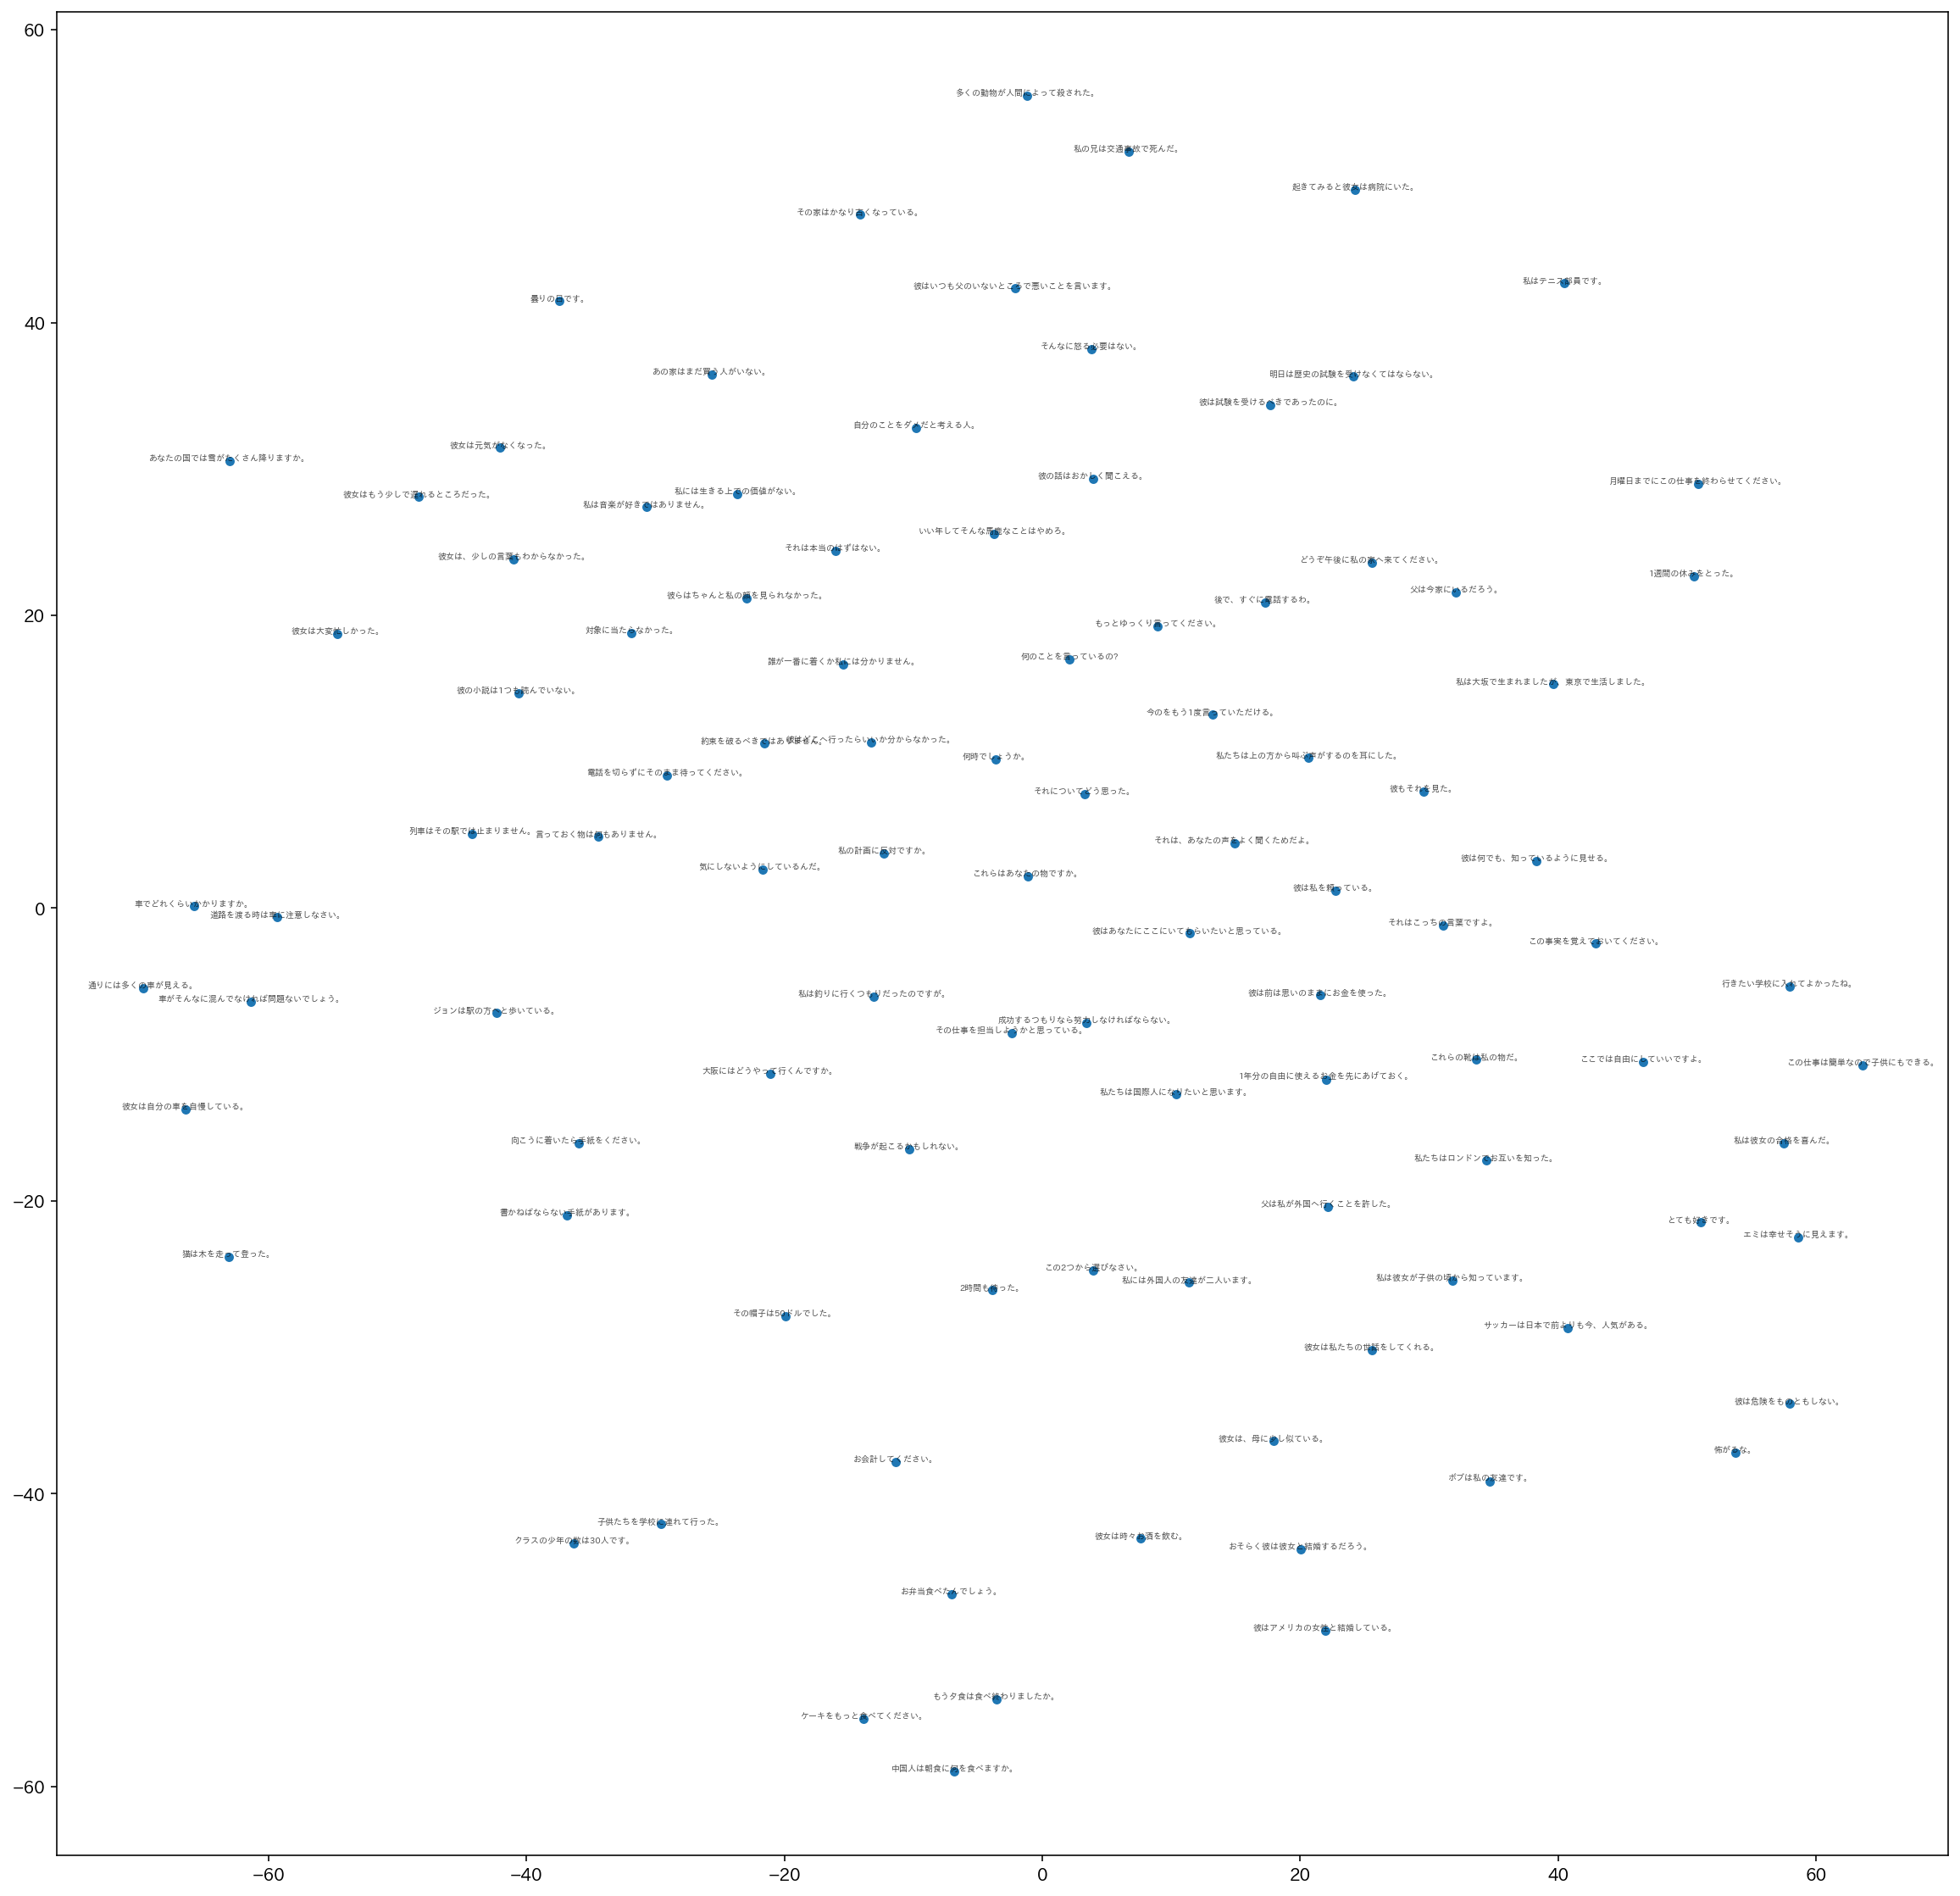

In [19]:
print(type(snow_vectors), snow_vectors.size())
N = 100
_Xvects = snow_vectors[:N,:]
_Xsents = snow_sents[:N]

calc_and_draw_tsne(model=sbert_model.model,
                   vectors=_Xvects,
                   tag=_Xsents,
                   fig_fname='2022_0807sbert_snow_tsne.pdf',
                   excel_fname='2022_0807sbert_snow_tsne_values.xlsx'
                  )

In [ ]:
calc_and_draw_tsne(model=sbert_model.model,
                   vectors=snow_vectors,
                   fig_fname='2022_0807sbert_snow_tsne.pdf',
                   excel_fname='2022_0807sbert_snow_tsne_values.xlsx'
                  )

Preprocessing the data using PCA...
